In [2]:
# Requirements: install needed libraries (run once)
%pip install -q datasets transformers ipywidgets tokenizers huggingface_hub tf-keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data preparation cell for arXiv summarization with truncation & JSONL export

import os
import json
import re
import random
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

# --------------------
# Config
# --------------------
seed = 42
max_input_length = 4096
max_target_length = 512
random.seed(seed)

os.makedirs("./data", exist_ok=True)

# --------------------
# Load dataset and select 15,000 random samples
# --------------------
raw_dataset = load_dataset("ccdv/arxiv-summarization", split="train")
raw_subset = raw_dataset.shuffle(seed=seed).select(range(15000))

# --------------------
# Ensure tokenizer (use existing `tokenizer` if already defined)
# --------------------
try:
    tokenizer  # noqa: F821
except NameError:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", use_fast=True)

# --------------------
# Text cleaning and truncation helpers
# --------------------
def clean_text(text: str) -> str:
    if text is None:
        return ""
    text = text.strip()
    # Collapse consecutive spaces/tabs
    text = re.sub(r"[ \t]+", " ", text)
    # Collapse repeated blank lines
    text = re.sub(r"\n\s*\n+", "\n\n", text)
    return text


def truncate_with_tokenizer(text: str, max_length: int) -> str:
    if not text:
        return ""
    enc = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        add_special_tokens=True,
    )
    return tokenizer.decode(enc["input_ids"], skip_special_tokens=True)


# --------------------
# Process subset: clean + truncate
# --------------------
processed_examples = []
for ex in raw_subset:
    article = clean_text(ex.get("article", ""))
    abstract = clean_text(ex.get("abstract", ""))

    input_text = truncate_with_tokenizer(article, max_input_length)
    target_text = truncate_with_tokenizer(abstract, max_target_length)

    processed_examples.append(
        {
            "input_text": input_text,
            "target_text": target_text,
        }
    )

dataset = Dataset.from_list(processed_examples)

# --------------------
# Train/Val/Test split: 80/10/10
# --------------------





tv_split = dataset.train_test_split(test_size=0.2, seed=seed)
train_dataset = tv_split["train"]          # 80%
temp_dataset = tv_split["test"]           # remaining 20%

vt_split = temp_dataset.train_test_split(test_size=0.5, seed=seed)
val_dataset = vt_split["train"]           # 10%
test_dataset = vt_split["test"]           # 10%


# --------------------
# Save as JSONL
# --------------------

def save_jsonl(ds: Dataset, path: str):
    with open(path, "w", encoding="utf-8") as f:
        for ex in ds:
            f.write(
                json.dumps(
                    {
                        "input_text": ex["input_text"],
                        "target_text": ex["target_text"],
                    },
                    ensure_ascii=False,
                )
                + "\n"
            )


save_jsonl(train_dataset, "./data/train.jsonl")
save_jsonl(val_dataset, "./data/val.jsonl")
save_jsonl(test_dataset, "./data/test.jsonl")


# --------------------
# Print counts and show 2 random examples from each split
# --------------------

print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}\n")


def show_random_examples(ds: Dataset, name: str, k: int = 2):
    print(f"=== {name} examples ===")
    indices = random.sample(range(len(ds)), k=min(k, len(ds)))
    for i in indices:
        ex = ds[i]
        print(f"\n--- {name} example idx {i} ---")
        print("INPUT_TEXT:\n", ex["input_text"][:1000], "\n")
        print("TARGET_TEXT:\n", ex["target_text"][:1000], "\n")


show_random_examples(train_dataset, "TRAIN", k=2)
show_random_examples(val_dataset, "VAL", k=2)
show_random_examples(test_dataset, "TEST", k=2)


Train size: 12000
Val size:   1500
Test size:  1500

=== TRAIN examples ===

--- TRAIN example idx 10476 ---
INPUT_TEXT:
 the in - spiral and coalescence of binary neutron star systems is a topic of increasingly intensive research in observational and theoretical astrophysics. 
 it is anticipated that the first direct detections of gravitational wave ( gw ) will be from compact binary mergers. 
 binary neutron star ( bns ) mergers are also thought to produce short - hard gamma - ray bursts ( sgrb s ) @xcite. 
 simultaneous detections of a prompt gravitational wave signal with a spatially coincident electromagnetic ( em ) counterpart dramatically increases the potential science return of the discovery. 
 for this reason, there has been considerable interest as to which, if any, detectable em signature may result from the merger @xcite. 
 other than sgrbs and their afterglows, including those viewed off - axis @xcite, suggestions include optical afterglows associated with the radio - act

In [3]:
   import torch
   print("CUDA available:", torch.cuda.is_available())
   print("Device count:", torch.cuda.device_count())

CUDA available: True
Device count: 1


In [4]:
# GPU LoRA fine-tuning cell for transformers==4.57.2 (replace your current training cell with this)

%pip install -q "transformers==4.57.2" "peft>=0.12.0" "accelerate>=0.33.0" datasets bitsandbytes

import os
import json
from typing import Dict, Any

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model

assert torch.cuda.is_available(), "CUDA GPU not available. Check your environment."
print("Using GPU:", torch.cuda.get_device_name(0))
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ----------------------
# Config
# ----------------------
BASE_MODEL = "meta-llama/Meta-Llama-3-8B"
DATA_DIR = "./data"
OUTPUT_DIR = "./lora_summarizer_llama3"

max_input_length = 4096
max_target_length = 512

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------
# Tokenizer
# ----------------------
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# ----------------------
# Load JSONL datasets
# ----------------------
data_files = {
    "train": os.path.join(DATA_DIR, "train.jsonl"),
    "validation": os.path.join(DATA_DIR, "val.jsonl"),
}
raw_datasets = load_dataset("json", data_files=data_files)
train_dataset = raw_datasets["train"]
eval_dataset = raw_datasets["validation"]

# ----------------------
# Tokenization
# ----------------------
def tokenize_example(example: Dict[str, Any]) -> Dict[str, Any]:
    prompt = (
        "Summarize the following scientific article.\n\n"
        "Article:\n"
        f"{example['input_text']}\n\n"
        "Summary:"
    )
    target = example["target_text"]

    prompt_ids = tokenizer(
        prompt,
        truncation=True,
        max_length=max_input_length,
        add_special_tokens=False,
    )["input_ids"]

    target_ids = tokenizer(
        target,
        truncation=True,
        max_length=max_target_length,
        add_special_tokens=False,
    )["input_ids"]

    eos_id = tokenizer.eos_token_id
    input_ids = prompt_ids + target_ids + ([eos_id] if eos_id is not None else [])
    labels = [-100] * len(prompt_ids) + target_ids + ([eos_id] if eos_id is not None else [])
    attention_mask = [1] * len(input_ids)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

tokenized_train = train_dataset.map(
    tokenize_example,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train data",
)
tokenized_eval = eval_dataset.map(
    tokenize_example,
    remove_columns=eval_dataset.column_names,
    desc="Tokenizing val data",
)

# ----------------------
# Base model on GPU
# ----------------------
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# ----------------------
# LoRA
# ----------------------
def get_lora_target_modules(m):
    module_names = {name.split(".")[-1] for name, _ in m.named_modules()}
    if "q_proj" in module_names and "v_proj" in module_names:
        return ["q_proj", "v_proj"]
    if "q" in module_names and "v" in module_names:
        return ["q", "v"]
    return ["q_proj", "v_proj"]

target_modules = get_lora_target_modules(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# recommended for PEFT + checkpointing
model.config.use_cache = False
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# ----------------------
# Data collator
# ----------------------
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest",
    label_pad_token_id=-100,
)

# ----------------------
# TrainingArguments (note: eval_strategy, optim from your signature)
# ----------------------
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    warmup_ratio=0.03,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    logging_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    fp16=False,
    bf16=True,  # RTX 5090 supports bf16
    gradient_checkpointing=True,
    lr_scheduler_type="cosine",
    optim="adamw_torch_fused",
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# ----------------------
# Save adapter + (optional) base model
# ----------------------
adapter_dir = os.path.join(OUTPUT_DIR, "lora_adapter")
full_model_dir = os.path.join(OUTPUT_DIR, "full_model")

os.makedirs(adapter_dir, exist_ok=True)
os.makedirs(full_model_dir, exist_ok=True)

model.save_pretrained(adapter_dir)
tokenizer.save_pretrained(adapter_dir)

base_model = getattr(model, "base_model", None)
if base_model is not None:
    base_model.save_pretrained(full_model_dir)
    tokenizer.save_pretrained(full_model_dir)

print("Training complete.")
print(f"LoRA adapter saved to: {adapter_dir}")
print(f"Full model (base) saved to: {full_model_dir}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


2025-11-25 10:19:03.024471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 10:19:03.053575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/workspace/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/wor

Using GPU: NVIDIA GeForce RTX 5090


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Tokenizing train data:   0%|          | 0/12000 [00:00<?, ? examples/s]

Tokenizing val data:   0%|          | 0/1500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

/tmp/ipykernel_351/667070552.py:178: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


trainable params: 3,407,872 || all params: 8,033,669,120 || trainable%: 0.0424


Step,Training Loss,Validation Loss
500,1.490800,1.445671
1000,1.478700,1.429347
1500,1.445000,1.421315
2000,1.440500,1.416832
2500,1.436600,1.413535
3000,1.455300,1.410811
3500,1.378000,1.409091
4000,1.401600,1.408062
4500,1.460800,1.407226
5000,1.431700,1.406914


Training complete.
LoRA adapter saved to: ./lora_summarizer_llama3/lora_adapter
Full model (base) saved to: ./lora_summarizer_llama3/full_model


In [5]:
import os

print(os.getcwd())  # should be /data/jupyter/Mujtaba/Assignment4
print(os.listdir("."))  # see if lora_summarizer_llama3 is here

if os.path.isdir("lora_summarizer_llama3"):
    print(os.listdir("lora_summarizer_llama3"))

/workspace
['jupyter', 'lora_summarizer_llama3', 'data', 'venv', 'tensorflow-2.20.0.dev0+selfbuilt-cp312-cp312-linux_x86_64.whl', 'tensorflow']
['lora_adapter', 'checkpoint-5500', 'checkpoint-6000', 'full_model', 'runs']


In [8]:
import os
import json
import csv
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ----------------------
# Config
# ----------------------
seed = 42
random.seed(seed)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DATA_DIR = "./data"
TEST_PATH = os.path.join(DATA_DIR, "test.jsonl")

BASE_MODEL_DIR = "./lora_summarizer_llama3/full_model"
LORA_ADAPTER_DIR = "./lora_summarizer_llama3/lora_adapter"

OUTPUT_DIR = "./outputs"
JSONL_OUT = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
CSV_OUT = os.path.join(OUTPUT_DIR, "comparisons.csv")

max_input_length = 4096
max_new_tokens = 512

os.makedirs(OUTPUT_DIR, exist_ok=True)

assert torch.cuda.is_available(), "CUDA GPU not available. Check your environment."
print("Using GPU:", torch.cuda.get_device_name(0))

# ----------------------
# Load test set and sample 10 examples
# ----------------------
test_records = []
with open(TEST_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        test_records.append(json.loads(line))

assert len(test_records) > 0, "Test set is empty."
samples = random.sample(test_records, k=min(10, len(test_records)))

print(f"Loaded {len(test_records)} test samples, using {len(samples)} for comparison.")

# ----------------------
# Load tokenizer and models (base + LoRA)
# ----------------------


# tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_DIR, use_fast=True)
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "left"
from transformers import AutoTokenizer

BASE_MODEL_NAME = "meta-llama/Meta-Llama-3-8B"  # same base model you trained

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_DIR,
    torch_dtype=dtype,
    device_map="auto",
)
base_model.eval()

lora_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_DIR,
    torch_dtype=dtype,
    device_map="auto",
)
lora_model = PeftModel.from_pretrained(lora_base, LORA_ADAPTER_DIR)
lora_model.eval()

# ----------------------
# Generation helper
# ----------------------
def generate_summary(model, input_text: str) -> str:
    prompt = (
        "Summarize the following scientific article.\n\n"
        "Article:\n"
        f"{input_text}\n\n"
        "Summary:"
    )
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.2,
            top_p=0.95,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    summary = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    return summary

# ----------------------
# Run generation and collect outputs
# ----------------------
results = []
for idx, ex in enumerate(samples):
    input_text = ex["input_text"]
    ground_truth = ex["target_text"]

    print(f"\n===== Example {idx} =====")
    print("Input (truncated):")
    print(input_text[:500] + ("..." if len(input_text) > 500 else ""))
    print("\nGround Truth:")
    print(ground_truth[:500] + ("..." if len(ground_truth) > 500 else ""))

    base_summary = generate_summary(base_model, input_text)
    lora_summary = generate_summary(lora_model, input_text)

    print("\nBase Summary:")
    print(base_summary[:500] + ("..." if len(base_summary) > 500 else ""))
    print("\nLoRA Summary:")
    print(lora_summary[:500] + ("..." if len(lora_summary) > 500 else ""))
    print("=" * 80)

    results.append(
        {
            "id": idx,
            "input_text": input_text,
            "ground_truth": ground_truth,
            "base_summary": base_summary,
            "lora_summary": lora_summary,
        }
    )

# ----------------------
# Save to JSONL
# ----------------------
with open(JSONL_OUT, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

# ----------------------
# Save to CSV
# ----------------------
with open(CSV_OUT, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "input_text", "ground_truth", "base_summary", "lora_summary"])
    for row in results:
        writer.writerow(
            [
                row["id"],
                row["input_text"],
                row["ground_truth"],
                row["base_summary"],
                row["lora_summary"],
            ]
        )

print(f"\nSaved JSONL to: {JSONL_OUT}")
print(f"Saved CSV to: {CSV_OUT}")

Using GPU: NVIDIA GeForce RTX 5090
Loaded 1500 test samples, using 10 for comparison.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./lora_summarizer_llama3/full_model were not used when initializing LlamaForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.layers.1.self_attn.q_proj.base_layer.weight', 'model.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.layers.1.self_attn.v_proj.base_layer.weight', 'model.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.layers.1.self_attn.v_proj.lora_B.default.weight', 'model.layers.10.self_attn.q_proj.base_layer.weight', 'model.layers.10.self_attn.q_proj.lora_A.default.weight', 'model.layers.10.self_attn.q_proj.lora_B.default.weight', 'model.layers.10.self_attn.v_proj.b

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./lora_summarizer_llama3/full_model were not used when initializing LlamaForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.layers.1.self_attn.q_proj.base_layer.weight', 'model.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.layers.1.self_attn.v_proj.base_layer.weight', 'model.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.layers.1.self_attn.v_proj.lora_B.default.weight', 'model.layers.10.self_attn.q_proj.base_layer.weight', 'model.layers.10.self_attn.q_proj.lora_A.default.weight', 'model.layers.10.self_attn.q_proj.lora_B.default.weight', 'model.layers.10.self_attn.v_proj.b


===== Example 0 =====
Input (truncated):
the current paradigm for the electronic structure of manganites ( a@xmath0b@xmath7mno@xmath2 ) with x @xmath8 1/2 is a lattice of mn sites with d@xmath9 or d@xmath10 orbital occupancy, with the proportion of each decided by the value of x and orbital ordering ( oo ) of the occupied e@xmath11 orbital on d@xmath10 sites. 
 the corresponding double - exchange model hamiltonian has been studied extensively @xcite. 
 manganites with x @xmath8 1/2 usually exhibit a phase transition @xcite which has be...

Ground Truth:
unrestricted hartree - fock calculations on la@xmath0ca@xmath1mno@xmath2 ( x = 0.5 and x = 0.67 ) in the full magnetic unit cell show that the magnetic ground states of these compounds consist of ferromagnetic molecules or polarons ordered in herring - bone patterns. 
 each polaron consists of either two or three mn ions separated by o@xmath3 ions with a magnetic moment opposed to those of the mn ions. 
 ferromagnetic coupling within t

OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 0 has a total capacity of 31.33 GiB of which 716.12 MiB is free. Including non-PyTorch memory, this process has 29.53 GiB memory in use. Of the allocated memory 28.63 GiB is allocated by PyTorch, and 319.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
import os
import json
import csv
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ----------------------
# Config
# ----------------------
seed = 42
random.seed(seed)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DATA_DIR = "./data"
TEST_PATH = os.path.join(DATA_DIR, "test.jsonl")

BASE_MODEL_NAME = "meta-llama/Meta-Llama-3-8B"   # same base model as training
BASE_MODEL_DIR = "./lora_summarizer_llama3/full_model"
LORA_ADAPTER_DIR = "./lora_summarizer_llama3/lora_adapter"

OUTPUT_DIR = "./outputs"
JSONL_OUT = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
CSV_OUT = os.path.join(OUTPUT_DIR, "comparisons.csv")

# Use smaller context at inference to avoid OOM
max_input_length = 2048
max_new_tokens = 256

os.makedirs(OUTPUT_DIR, exist_ok=True)

assert torch.cuda.is_available(), "CUDA GPU not available. Check your environment."
print("Using GPU:", torch.cuda.get_device_name(0))

# ----------------------
# Load test set and sample 10 examples
# ----------------------
test_records = []
with open(TEST_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        test_records.append(json.loads(line))

assert len(test_records) > 0, "Test set is empty."
samples = random.sample(test_records, k=min(10, len(test_records)))
print(f"Loaded {len(test_records)} test samples, using {len(samples)} for comparison.")

# ----------------------
# Tokenizer (from base model name, not local dir)
# ----------------------
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

# ----------------------
# Generation helper
# ----------------------
def generate_summary(model, input_text: str) -> str:
    prompt = (
        "Summarize the following scientific article.\n\n"
        "Article:\n"
        f"{input_text}\n\n"
        "Summary:"
    )
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.2,
            top_p=0.95,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    summary = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    return summary

# ----------------------
# First pass: base model summaries (only base model in GPU)
# ----------------------
print("\n=== Generating base model summaries ===")
base_summaries = []

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_DIR,
    torch_dtype=dtype,
    device_map="auto",
)
base_model.eval()

for idx, ex in enumerate(samples):
    input_text = ex["input_text"]
    base_summary = generate_summary(base_model, input_text)
    base_summaries.append(base_summary)

# Free GPU memory used by base model
del base_model
torch.cuda.empty_cache()

# ----------------------
# Second pass: LoRA model summaries
# ----------------------
print("\n=== Generating LoRA model summaries ===")
lora_summaries = []

lora_base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_DIR,
    torch_dtype=dtype,
    device_map="auto",
)
lora_model = PeftModel.from_pretrained(lora_base, LORA_ADAPTER_DIR)
lora_model.eval()

for idx, ex in enumerate(samples):
    input_text = ex["input_text"]
    lora_summary = generate_summary(lora_model, input_text)
    lora_summaries.append(lora_summary)

# Free GPU memory used by LoRA model (optional)
del lora_model
del lora_base
torch.cuda.empty_cache()

# ----------------------
# Collect results, print side-by-side, and save
# ----------------------
results = []
for i, ex in enumerate(samples):
    input_text = ex["input_text"]
    ground_truth = ex["target_text"]
    base_summary = base_summaries[i]
    lora_summary = lora_summaries[i]

    print(f"\n===== Example {i} =====")
    print("Input (truncated):")
    print(input_text[:500] + ("..." if len(input_text) > 500 else ""))
    print("\nGround Truth:")
    print(ground_truth[:500] + ("..." if len(ground_truth) > 500 else ""))
    print("\nBase Summary:")
    print(base_summary[:500] + ("..." if len(base_summary) > 500 else ""))
    print("\nLoRA Summary:")
    print(lora_summary[:500] + ("..." if len(lora_summary) > 500 else ""))
    print("=" * 80)

    results.append(
        {
            "id": i,
            "input_text": input_text,
            "ground_truth": ground_truth,
            "base_summary": base_summary,
            "lora_summary": lora_summary,
        }
    )

# Save to JSONL
with open(JSONL_OUT, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

# Save to CSV
with open(CSV_OUT, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "input_text", "ground_truth", "base_summary", "lora_summary"])
    for row in results:
        writer.writerow(
            [
                row["id"],
                row["input_text"],
                row["ground_truth"],
                row["base_summary"],
                row["lora_summary"],
            ]
        )

print(f"\nSaved JSONL to: {JSONL_OUT}")
print(f"Saved CSV to: {CSV_OUT}")

Using GPU: NVIDIA GeForce RTX 5090
Loaded 1500 test samples, using 10 for comparison.

=== Generating base model summaries ===


/workspace/venv/lib/python3.12/site-packages/accelerate/utils/modeling.py:1566: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./lora_summarizer_llama3/full_model were not used when initializing LlamaForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.layers.1.self_attn.q_proj.base_layer.weight', 'model.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.layers.1.self_attn.v_proj.base_layer.weight', 'model.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.layers.1.self_attn.v_proj.lora_B.default.weight', 'model.layers.10.self_attn.q_proj.base_layer.weight', 'model.layers.10.self_attn.q_proj.lora_A.default.weight', 'model.layers.10.self_attn.q_proj.lora_B.default.weight', 'model.layers.10.self_attn.v_proj.b


=== Generating LoRA model summaries ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./lora_summarizer_llama3/full_model were not used when initializing LlamaForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.layers.1.self_attn.q_proj.base_layer.weight', 'model.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.layers.1.self_attn.v_proj.base_layer.weight', 'model.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.layers.1.self_attn.v_proj.lora_B.default.weight', 'model.layers.10.self_attn.q_proj.base_layer.weight', 'model.layers.10.self_attn.q_proj.lora_A.default.weight', 'model.layers.10.self_attn.q_proj.lora_B.default.weight', 'model.layers.10.self_attn.v_proj.b


===== Example 0 =====
Input (truncated):
the current paradigm for the electronic structure of manganites ( a@xmath0b@xmath7mno@xmath2 ) with x @xmath8 1/2 is a lattice of mn sites with d@xmath9 or d@xmath10 orbital occupancy, with the proportion of each decided by the value of x and orbital ordering ( oo ) of the occupied e@xmath11 orbital on d@xmath10 sites. 
 the corresponding double - exchange model hamiltonian has been studied extensively @xcite. 
 manganites with x @xmath8 1/2 usually exhibit a phase transition @xcite which has be...

Ground Truth:
unrestricted hartree - fock calculations on la@xmath0ca@xmath1mno@xmath2 ( x = 0.5 and x = 0.67 ) in the full magnetic unit cell show that the magnetic ground states of these compounds consist of ferromagnetic molecules or polarons ordered in herring - bone patterns. 
 each polaron consists of either two or three mn ions separated by o@xmath3 ions with a magnetic moment opposed to those of the mn ions. 
 ferromagnetic coupling within t

Note: you may need to restart the kernel to use updated packages.
Loaded 10 comparison records.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Metric Summary (mean ± std) ===
Metric             Base_mean     Base_std    LoRA_mean     LoRA_std
rouge1                0.0000       0.0000       0.0000       0.0000
rouge2                0.0000       0.0000       0.0000       0.0000
rougeL                0.0000       0.0000       0.0000       0.0000
bleu                  0.0000       0.0000       0.0000       0.0000
bertscore_f1          0.6800       0.0069       0.6866       0.0132


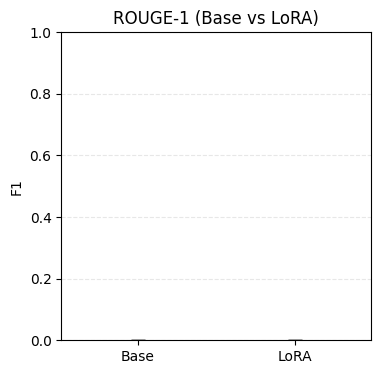

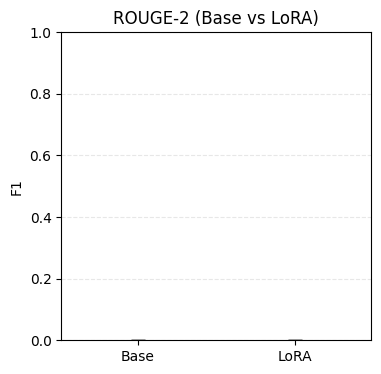

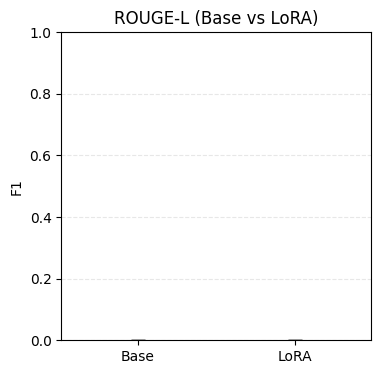

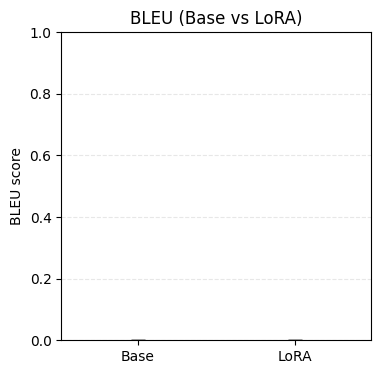

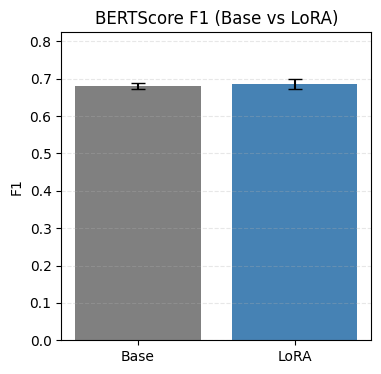


Saved metrics summary to: ./outputs/metrics_summary.json


In [11]:
# Part 4.A — Automatic Evaluation: ROUGE, BLEU, BERTScore + plots

%pip install -q evaluate rouge-score nltk bert-score matplotlib

import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt

import evaluate
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

# ----------------------
# Config & paths
# ----------------------
OUTPUT_DIR = "./outputs"
COMPARISONS_PATH = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
METRICS_SUMMARY_PATH = os.path.join(OUTPUT_DIR, "metrics_summary.json")
os.makedirs(OUTPUT_DIR, exist_ok=True)

random.seed(42)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ----------------------
# Load comparisons.jsonl
# ----------------------
records = []
with open(COMPARISONS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

assert len(records) > 0, "No records found in comparisons.jsonl"

ground_truths = [r["ground_truth"] for r in records]
base_summaries = [r["base_summary"] for r in records]
lora_summaries = [r["lora_summary"] for r in records]

print(f"Loaded {len(records)} comparison records.")

# ----------------------
# ROUGE (using evaluate)
# ----------------------
rouge_metric = evaluate.load("rouge")

rouge_base = rouge_metric.compute(
    predictions=base_summaries,
    references=ground_truths,
    use_aggregator=False,
)
rouge_lora = rouge_metric.compute(
    predictions=lora_summaries,
    references=ground_truths,
    use_aggregator=False,
)

# rouge_base / rouge_lora keys: 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'
# We will use rouge1, rouge2, rougeL
rouge_metrics = ["rouge1", "rouge2", "rougeL"]

# ----------------------
# BLEU (sentence-level with smoothing)
# ----------------------
smooth_fn = SmoothingFunction().method1

def compute_bleu_list(preds, refs):
    scores = []
    for hyp, ref in zip(preds, refs):
        hyp_tokens = hyp.split()
        ref_tokens = ref.split()
        if len(hyp_tokens) == 0 or len(ref_tokens) == 0:
            scores.append(0.0)
            continue
        scores.append(
            sentence_bleu(
                [ref_tokens],
                hyp_tokens,
                smoothing_function=smooth_fn,
            )
        )
    return scores

bleu_base = compute_bleu_list(base_summaries, ground_truths)
bleu_lora = compute_bleu_list(lora_summaries, ground_truths)

# ----------------------
# BERTScore (F1 only)
# ----------------------
device = "cpu"

P_b, R_b, F1_b = bert_score(
    base_summaries,
    ground_truths,
    lang="en",
    device=device,
    verbose=False,
)
P_l, R_l, F1_l = bert_score(
    lora_summaries,
    ground_truths,
    lang="en",
    device=device,
    verbose=False,
)

bertscore_f1_base = F1_b.tolist()
bertscore_f1_lora = F1_l.tolist()

# ----------------------
# Aggregate metrics: mean & std
# ----------------------
def mean_std(values):
    arr = np.array(values, dtype=float)
    return float(arr.mean()), float(arr.std(ddof=0))

metrics_summary = {}

# ROUGE
for m in rouge_metrics:
    base_vals = rouge_base[m]
    lora_vals = rouge_lora[m]
    b_mean, b_std = mean_std(base_vals)
    l_mean, l_std = mean_std(lora_vals)
    metrics_summary[m] = {
        "base": {"mean": b_mean, "std": b_std},
        "lora": {"mean": l_mean, "std": l_std},
    }

# BLEU
b_mean, b_std = mean_std(bleu_base)
l_mean, l_std = mean_std(bleu_lora)
metrics_summary["bleu"] = {
    "base": {"mean": b_mean, "std": b_std},
    "lora": {"mean": l_mean, "std": l_std},
}

# BERTScore F1
b_mean, b_std = mean_std(bertscore_f1_base)
l_mean, l_std = mean_std(bertscore_f1_lora)
metrics_summary["bertscore_f1"] = {
    "base": {"mean": b_mean, "std": b_std},
    "lora": {"mean": l_mean, "std": l_std},
}

# ----------------------
# Print numeric table
# ----------------------
print("\n=== Metric Summary (mean ± std) ===")
print(f"{'Metric':<15} {'Base_mean':>12} {'Base_std':>12} {'LoRA_mean':>12} {'LoRA_std':>12}")
for metric_name, vals in metrics_summary.items():
    b = vals["base"]
    l = vals["lora"]
    print(
        f"{metric_name:<15} "
        f"{b['mean']:>12.4f} {b['std']:>12.4f} "
        f"{l['mean']:>12.4f} {l['std']:>12.4f}"
    )

# ----------------------
# Bar plots (Base vs LoRA) for each metric
# ----------------------
def plot_metric(metric_key, title=None, ylabel=None):
    base_mean = metrics_summary[metric_key]["base"]["mean"]
    base_std = metrics_summary[metric_key]["base"]["std"]
    lora_mean = metrics_summary[metric_key]["lora"]["mean"]
    lora_std = metrics_summary[metric_key]["lora"]["std"]

    labels = ["Base", "LoRA"]
    means = [base_mean, lora_mean]
    stds = [base_std, lora_std]

    plt.figure(figsize=(4, 4))
    plt.bar(labels, means, yerr=stds, capsize=5, color=["gray", "steelblue"])
    plt.title(title or metric_key)
    plt.ylabel(ylabel or "Score")
    plt.ylim(0, max(means) * 1.2 if max(means) > 0 else 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.show()

plot_metric("rouge1", title="ROUGE-1 (Base vs LoRA)", ylabel="F1")
plot_metric("rouge2", title="ROUGE-2 (Base vs LoRA)", ylabel="F1")
plot_metric("rougeL", title="ROUGE-L (Base vs LoRA)", ylabel="F1")
plot_metric("bleu", title="BLEU (Base vs LoRA)", ylabel="BLEU score")
plot_metric("bertscore_f1", title="BERTScore F1 (Base vs LoRA)", ylabel="F1")

# ----------------------
# Save metrics_summary.json
# ----------------------
with open(METRICS_SUMMARY_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=2)

print(f"\nSaved metrics summary to: {METRICS_SUMMARY_PATH}")

In [ ]:
GEMINI_API_KEY="AIza****************************"

In [28]:
# Part 4.B — LLM-as-a-Judge using Gemini 2.5 Flash (instead of Together.ai)
# - Evaluates 10 samples (base vs LoRA) on Fluency, Factuality, Coverage
# - Saves ./outputs/llm_judge_scores_gemini.json

%pip install -q google-generativeai

import os
import json
import random
import statistics
import textwrap
import google.generativeai as genai

# ----------------------
# Config
# ----------------------
OUTPUT_DIR = "./outputs"
COMPARISONS_PATH = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
LLM_JUDGE_OUT = os.path.join(OUTPUT_DIR, "llm_judge_scores_gemini.json")

os.makedirs(OUTPUT_DIR, exist_ok=True)

GEMINI_MODEL_NAME = "gemini-2.5-flash"       # LLM-as-a-Judge model

MAX_INPUT_CHARS = 4000  # trim long texts for the judge
NUM_SAMPLES = 10
random.seed(42)

genai.configure(api_key=GEMINI_API_KEY)
judge_model = genai.GenerativeModel(GEMINI_MODEL_NAME)

# ----------------------
# Exact LLM-as-a-Judge prompt (SYSTEM + USER) with placeholders
# ----------------------
JUDGE_PROMPT_TEMPLATE = """SYSTEM: You are a strict evaluator. Rate the generated summary along three dimensions from 1 (poor) to 5 (excellent). Provide only a JSON object as the final output.

USER:

Input: <<INPUT_TEXT>>

Ground-Truth Abstract: <<GROUND_TRUTH>>

Generated Summary: <<GENERATED_SUMMARY>>

Instructions:

- For each dimension (fluency, factuality, coverage) return:

  - "score": integer 1-5

  - "justification": a short justification (max 40 words)

  - "errors": a short list (max 3 items) describing factual errors or hallucinations; if none, return [].

- Return a single valid JSON object with keys: "fluency", "factuality", "coverage".

- Example output:

{
  "fluency": {"score": 4, "justification": "Readable and grammatical", "errors": []},
  "factuality": {"score": 3, "justification": "Missed experimental detail", "errors": ["Says dataset size is 1.5k rather than 15k"]},
  "coverage": {"score": 2, "justification": "Omits method description", "errors": ["No mention of optimization method"]}
}
"""

def truncate_text(text: str, max_chars: int = MAX_INPUT_CHARS) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars] + "\n\n(TRUNCATED)"

def build_judge_prompt(input_text: str, ground_truth: str, generated_summary: str) -> str:
    return (
        JUDGE_PROMPT_TEMPLATE
        .replace("<<INPUT_TEXT>>", truncate_text(input_text))
        .replace("<<GROUND_TRUTH>>", truncate_text(ground_truth))
        .replace("<<GENERATED_SUMMARY>>", truncate_text(generated_summary))
    )

# ----------------------
# Single Gemini call for one judgment
# ----------------------
def call_gemini_judge(input_text: str,
                      ground_truth: str,
                      generated_summary: str) -> dict:
    """
    Calls Gemini 2.5 Flash with the specified SYSTEM/USER-style prompt.
    Returns parsed JSON dict with keys: fluency, factuality, coverage.
    If Gemini returns no text (e.g., due to safety), returns a neutral fallback.
    """
    prompt = build_judge_prompt(input_text, ground_truth, generated_summary)

    response = judge_model.generate_content(
        prompt,
        generation_config={
            "temperature": 0.0,
            "max_output_tokens": 512,
        },
    )

    # Helper: neutral fallback if model gives no usable text
    def fallback_judgment(reason: str = "no_output"):
        return {
            "fluency":   {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "factuality":{"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "coverage":  {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
        }

    # Safely extract text from candidates without using response.text
    if not getattr(response, "candidates", None):
        return fallback_judgment("no_candidates")

    candidate = response.candidates[0]
    parts = getattr(candidate, "content", candidate).parts if hasattr(candidate, "content") else []

    texts = []
    for p in parts:
        t = getattr(p, "text", None)
        if t:
            texts.append(t)
    content = "\n".join(texts).strip()

    if not content:
        # Nothing usable produced (likely safety/max_tokens), return fallback
        return fallback_judgment("empty_content")

    # Robust JSON extraction: substring between first '{' and last '}'
    try:
        start = content.index("{")
        end = content.rindex("}") + 1
        json_str = content[start:end]
    except ValueError:
        json_str = content  # fallback to entire content

    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        json_str_fixed = json_str.replace("\n", " ").replace("\t", " ")
        try:
            parsed = json.loads(json_str_fixed)
        except json.JSONDecodeError:
            # If still broken, return fallback
            return fallback_judgment("json_parse_error")

    return parsed
# ----------------------
# Run evaluation over 10 samples (base vs LoRA)
# ----------------------
# Safer version: handles API errors / quota limits and still saves partial results

# Stateful / resumable Gemini LLM-as-a-Judge evaluation:
# - Reuses existing ./outputs/llm_judge_scores_gemini.json if present
# - Only calls Gemini for samples that have NOT been evaluated yet

def run_gemini_llm_judge_evaluation():
    """
    Runs LLM-as-a-Judge over up to NUM_SAMPLES examples.
    - If llm_judge_scores_gemini.json exists, reuses previously evaluated samples.
    - Only sends Gemini requests for remaining samples.
    - On any API error, stops further calls but still saves all accumulated results.
    """
    # Load comparisons.jsonl
    records = []
    with open(COMPARISONS_PATH, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            # Ensure each record has a stable id
            if "id" not in rec:
                rec["id"] = idx
            records.append(rec)

    if len(records) == 0:
        raise RuntimeError("No records found in comparisons.jsonl")

    # Map id -> record
    id_to_rec = {rec["id"]: rec for rec in records}
    all_ids = sorted(id_to_rec.keys())
    target_ids = all_ids[:min(NUM_SAMPLES, len(all_ids))]

    print(f"Target IDs for evaluation (up to {NUM_SAMPLES}): {target_ids}")

    # ----------------------
    # Load existing results if file exists
    # ----------------------
    all_scores = {
        "base": {"fluency": [], "factuality": [], "coverage": []},
        "lora": {"fluency": [], "factuality": [], "coverage": []},
    }
    per_sample = []
    evaluated_ids = set()

    if os.path.exists(LLM_JUDGE_OUT):
        try:
            with open(LLM_JUDGE_OUT, "r", encoding="utf-8") as f:
                existing = json.load(f)
            for entry in existing.get("per_sample", []):
                rid = entry.get("id")
                if rid in target_ids:
                    per_sample.append(entry)
                    evaluated_ids.add(rid)
                    for which in ["base", "lora"]:
                        for dim in ["fluency", "factuality", "coverage"]:
                            score = int(entry[which][dim]["score"])
                            all_scores[which][dim].append(score)
            print(f"Loaded existing judgments for IDs: {sorted(evaluated_ids)}")
        except Exception as e:
            print(f"[Warning] Failed to load existing {LLM_JUDGE_OUT}: {e}")
    else:
        print("No existing llm_judge_scores_gemini.json found; starting fresh.")

    remaining_ids = [rid for rid in target_ids if rid not in evaluated_ids]
    print(f"Remaining IDs to evaluate: {remaining_ids}")

    # ----------------------
    # Evaluate remaining samples
    # ----------------------
    for rid in remaining_ids:
        rec = id_to_rec[rid]
        input_text = rec["input_text"]
        ground_truth = rec["ground_truth"]
        base_summary = rec["base_summary"]
        lora_summary = rec["lora_summary"]

        print(f"\n=== Evaluating id={rid} ===")
        try:
            print("Calling Gemini judge for BASE summary...")
            base_judgment = call_gemini_judge(input_text, ground_truth, base_summary)

            print("Calling Gemini judge for LoRA summary...")
            lora_judgment = call_gemini_judge(input_text, ground_truth, lora_summary)

            # Parse and store scores
            for dim in ["fluency", "factuality", "coverage"]:
                b_score = int(base_judgment[dim]["score"])
                l_score = int(lora_judgment[dim]["score"])
                all_scores["base"][dim].append(b_score)
                all_scores["lora"][dim].append(l_score)

            per_sample.append(
                {
                    "id": rid,
                    "base": base_judgment,
                    "lora": lora_judgment,
                }
            )
            evaluated_ids.add(rid)

        except Exception as e:
            print(f"\n[Warning] Stopping evaluation due to error on id={rid}: {e}")
            break

    evaluated_n = len(evaluated_ids)
    if evaluated_n == 0:
        print("\nNo samples were successfully evaluated; nothing to save.")
        return

    print(f"\nFinished with {evaluated_n} successfully evaluated unique IDs.")

    # ----------------------
    # Aggregate averages
    # ----------------------
    summary = {
        "provider": "gemini",
        "model": GEMINI_MODEL_NAME,
        "num_samples_requested": len(target_ids),
        "num_samples_evaluated": evaluated_n,
        "evaluated_ids": sorted(evaluated_ids),
        "per_sample": per_sample,
        "avg": {},
    }

    for which in ["base", "lora"]:
        summary["avg"][which] = {}
        for dim in ["fluency", "factuality", "coverage"]:
            scores = all_scores[which][dim]
            if scores:
                mean_val = float(statistics.mean(scores))
                std_val = float(statistics.pstdev(scores)) if len(scores) > 1 else 0.0
            else:
                mean_val, std_val = 0.0, 0.0
            summary["avg"][which][dim] = {
                "mean": mean_val,
                "std": std_val,
                "scores": scores,
            }

    # ----------------------
    # Save JSON
    # ----------------------
    with open(LLM_JUDGE_OUT, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

    print(f"\nSaved Gemini LLM-as-a-Judge scores to: {LLM_JUDGE_OUT}")
    print("Average scores (mean over evaluated samples):")
    for which in ["base", "lora"]:
        print(f"\n{which.upper()}:")
        for dim in ["fluency", "factuality", "coverage"]:
            stats_dim = summary["avg"][which][dim]
            print(
                f"  {dim}: mean={stats_dim['mean']:.2f}, "
                f"std={stats_dim['std']:.2f}, scores={stats_dim['scores']}"
            )

# ----------------------
# Example: run the evaluation once API key is set
# ----------------------
# run_gemini_llm_judge_evaluation()

Note: you may need to restart the kernel to use updated packages.


In [15]:
import google.generativeai

In [29]:
run_gemini_llm_judge_evaluation()

Target IDs for evaluation (up to 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Loaded existing judgments for IDs: [0, 1, 4, 6, 9]
Remaining IDs to evaluate: [2, 3, 5, 7, 8]

=== Evaluating id=2 ===
Calling Gemini judge for BASE summary...
Calling Gemini judge for LoRA summary...

=== Evaluating id=3 ===
Calling Gemini judge for BASE summary...
Calling Gemini judge for LoRA summary...

=== Evaluating id=5 ===
Calling Gemini judge for BASE summary...
Calling Gemini judge for LoRA summary...

=== Evaluating id=7 ===
Calling Gemini judge for BASE summary...
Calling Gemini judge for LoRA summary...

=== Evaluating id=8 ===
Calling Gemini judge for BASE summary...
Calling Gemini judge for LoRA summary...

Finished with 10 successfully evaluated unique IDs.

Saved Gemini LLM-as-a-Judge scores to: ./outputs/llm_judge_scores_gemini.json
Average scores (mean over evaluated samples):

BASE:
  fluency: mean=3.00, std=0.00, scores=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
  factuality: mean=3.00, std=0.00, scores=[3, 3

In [35]:
# Part 4.B — LLM-as-a-Judge using Groq (llama-3.3-70b-versatile)
# - Evaluates up to NUM_SAMPLES samples (base vs LoRA)
# - Saves ./outputs/llm_judge_scores_groq.json
# - Resumable: reuses previous results and only judges missing ids

%pip install -q groq

import os
import json
import random
import statistics
from groq import Groq

# ----------------------
# Config
# ----------------------
OUTPUT_DIR = "./outputs"
COMPARISONS_PATH = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
LLM_JUDGE_OUT = os.path.join(OUTPUT_DIR, "llm_judge_scores_groq.json")

os.makedirs(OUTPUT_DIR, exist_ok=True)


GROQ_MODEL_NAME = "llama-3.3-70b-versatile"

NUM_SAMPLES = 10
MAX_INPUT_CHARS = 4000
random.seed(42)

client = Groq(api_key=GROQ_API_KEY)

# ----------------------
# Exact LLM-as-a-Judge prompt (SYSTEM + USER) as specified
# ----------------------
SYSTEM_PROMPT = (
    "You are a strict evaluator. Rate the generated summary along three dimensions from 1 (poor) "
    "to 5 (excellent). Provide only a JSON object as the final output."
)

USER_PROMPT_TEMPLATE = """Input: <<INPUT_TEXT>>

Ground-Truth Abstract: <<GROUND_TRUTH>>

Generated Summary: <<GENERATED_SUMMARY>>

Instructions:

- For each dimension (fluency, factuality, coverage) return:

  - "score": integer 1-5

  - "justification": a short justification (max 40 words)

  - "errors": a short list (max 3 items) describing factual errors or hallucinations; if none, return [].

- Return a single valid JSON object with keys: "fluency", "factuality", "coverage".

- Example output:

{
  "fluency": {"score": 4, "justification": "Readable and grammatical", "errors": []},
  "factuality": {"score": 3, "justification": "Missed experimental detail", "errors": ["Says dataset size is 1.5k rather than 15k"]},
  "coverage": {"score": 2, "justification": "Omits method description", "errors": ["No mention of optimization method"]}
}
"""

def truncate_text(text: str, max_chars: int = MAX_INPUT_CHARS) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars] + "\n\n(TRUNCATED)"

def build_user_prompt(input_text: str, ground_truth: str, generated_summary: str) -> str:
    return (
        USER_PROMPT_TEMPLATE
        .replace("<<INPUT_TEXT>>", truncate_text(input_text))
        .replace("<<GROUND_TRUTH>>", truncate_text(ground_truth))
        .replace("<<GENERATED_SUMMARY>>", truncate_text(generated_summary))
    )

# ----------------------
# Single Groq call for one judgment
# ----------------------
def call_groq_judge(input_text: str,
                    ground_truth: str,
                    generated_summary: str) -> dict:
    """
    Calls Groq (llama-3.3-70b-versatile) with the SYSTEM/USER prompt.
    Returns parsed JSON dict with keys: fluency, factuality, coverage.
    On bad JSON or empty content, returns a neutral fallback.
    """
    user_prompt = build_user_prompt(input_text, ground_truth, generated_summary)

    completion = client.chat.completions.create(
        model=GROQ_MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.0,
        max_completion_tokens=512,
        top_p=1.0,
        stream=False,
    )

    def fallback_judgment(reason: str = "no_output"):
        return {
            "fluency":   {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "factuality":{"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "coverage":  {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
        }

    if not completion.choices:
        return fallback_judgment("no_choices")

    content = (completion.choices[0].message.content or "").strip()
    if not content:
        return fallback_judgment("empty_content")

    # Extract JSON between first { and last }
    try:
        start = content.index("{")
        end = content.rindex("}") + 1
        json_str = content[start:end]
    except ValueError:
        json_str = content

    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        json_str_fixed = json_str.replace("\n", " ").replace("\t", " ")
        try:
            parsed = json.loads(json_str_fixed)
        except json.JSONDecodeError:
            return fallback_judgment("json_parse_error")

    return parsed

# ----------------------
# Resumable evaluation over up to NUM_SAMPLES samples
# ----------------------
def run_groq_llm_judge_evaluation():
    """
    Runs LLM-as-a-Judge over up to NUM_SAMPLES examples.
    - If llm_judge_scores_groq.json exists, reuses previous results.
    - Only calls Groq for remaining ids.
    - On API error, stops and still saves accumulated results.
    """
    # Load comparisons.jsonl
    records = []
    with open(COMPARISONS_PATH, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if "id" not in rec:
                rec["id"] = idx
            records.append(rec)

    if not records:
        raise RuntimeError("No records found in comparisons.jsonl")

    id_to_rec = {rec["id"]: rec for rec in records}
    all_ids = sorted(id_to_rec.keys())
    target_ids = all_ids[:min(NUM_SAMPLES, len(all_ids))]

    print(f"Target IDs for evaluation (up to {NUM_SAMPLES}): {target_ids}")

    # Prepare containers
    all_scores = {
        "base": {"fluency": [], "factuality": [], "coverage": []},
        "lora": {"fluency": [], "factuality": [], "coverage": []},
    }
    per_sample = []
    evaluated_ids = set()

    # Load existing results if any
    if os.path.exists(LLM_JUDGE_OUT):
        try:
            with open(LLM_JUDGE_OUT, "r", encoding="utf-8") as f:
                existing = json.load(f)
            for entry in existing.get("per_sample", []):
                rid = entry.get("id")
                if rid in target_ids:
                    per_sample.append(entry)
                    evaluated_ids.add(rid)
                    for which in ["base", "lora"]:
                        for dim in ["fluency", "factuality", "coverage"]:
                            score = int(entry[which][dim]["score"])
                            all_scores[which][dim].append(score)
            print(f"Loaded existing judgments for IDs: {sorted(evaluated_ids)}")
        except Exception as e:
            print(f"[Warning] Failed to load existing {LLM_JUDGE_OUT}: {e}")
    else:
        print("No existing llm_judge_scores_groq.json found; starting fresh.")

    remaining_ids = [rid for rid in target_ids if rid not in evaluated_ids]
    print(f"Remaining IDs to evaluate: {remaining_ids}")

    # Evaluate remaining
    for rid in remaining_ids:
        rec = id_to_rec[rid]
        input_text = rec["input_text"]
        ground_truth = rec["ground_truth"]
        base_summary = rec["base_summary"]
        lora_summary = rec["lora_summary"]

        print(f"\n=== Evaluating id={rid} ===")
        try:
            print("Calling Groq judge for BASE summary...")
            base_judgment = call_groq_judge(input_text, ground_truth, base_summary)

            print("Calling Groq judge for LoRA summary...")
            lora_judgment = call_groq_judge(input_text, ground_truth, lora_summary)

            for dim in ["fluency", "factuality", "coverage"]:
                b_score = int(base_judgment[dim]["score"])
                l_score = int(lora_judgment[dim]["score"])
                all_scores["base"][dim].append(b_score)
                all_scores["lora"][dim].append(l_score)

            per_sample.append(
                {
                    "id": rid,
                    "base": base_judgment,
                    "lora": lora_judgment,
                }
            )
            evaluated_ids.add(rid)

        except Exception as e:
            print(f"\n[Warning] Stopping evaluation due to error on id={rid}: {e}")
            break

    if not evaluated_ids:
        print("\nNo samples were successfully evaluated; nothing to save.")
        return

    print(f"\nFinished with {len(evaluated_ids)} successfully evaluated unique IDs.")

    # Aggregate averages
    summary = {
        "provider": "groq",
        "model": GROQ_MODEL_NAME,
        "num_samples_requested": len(target_ids),
        "num_samples_evaluated": len(evaluated_ids),
        "evaluated_ids": sorted(evaluated_ids),
        "per_sample": per_sample,
        "avg": {},
    }

    for which in ["base", "lora"]:
        summary["avg"][which] = {}
        for dim in ["fluency", "factuality", "coverage"]:
            scores = all_scores[which][dim]
            if scores:
                mean_val = float(statistics.mean(scores))
                std_val = float(statistics.pstdev(scores)) if len(scores) > 1 else 0.0
            else:
                mean_val = std_val = 0.0
            summary["avg"][which][dim] = {
                "mean": mean_val,
                "std": std_val,
                "scores": scores,
            }

    with open(LLM_JUDGE_OUT, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

    print(f"\nSaved Groq LLM-as-a-Judge scores to: {LLM_JUDGE_OUT}")
    print("Average scores (mean over evaluated samples):")
    for which in ["base", "lora"]:
        print(f"\n{which.upper()}:")
        for dim in ["fluency", "factuality", "coverage"]:
            stats_dim = summary["avg"][which][dim]
            print(
                f"  {dim}: mean={stats_dim['mean']:.2f}, "
                f"std={stats_dim['std']:.2f}, scores={stats_dim['scores']}"
            )

# To run once your GROQ_API_KEY is set:
# run_groq_llm_judge_evaluation()

Note: you may need to restart the kernel to use updated packages.


In [36]:
run_groq_llm_judge_evaluation()

Target IDs for evaluation (up to 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
No existing llm_judge_scores_groq.json found; starting fresh.
Remaining IDs to evaluate: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

=== Evaluating id=0 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=1 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=2 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=3 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=4 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=5 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=6 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoRA summary...

=== Evaluating id=7 ===
Calling Groq judge for BASE summary...
Calling Groq judge for LoR

## Updated sys prompt

In [37]:
# Part 4.B — LLM-as-a-Judge using Groq (llama-3.3-70b-versatile)
# - Evaluates up to NUM_SAMPLES samples (base vs LoRA)
# - Saves ./outputs/llm_judge_scores_groq.json
# - Resumable: reuses previous results and only judges missing ids

%pip install -q groq

import os
import json
import random
import statistics
from groq import Groq

# ----------------------
# Config
# ----------------------
OUTPUT_DIR = "./outputs"
COMPARISONS_PATH = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
LLM_JUDGE_OUT = os.path.join(OUTPUT_DIR, "llm_judge_scores_groq.json")

os.makedirs(OUTPUT_DIR, exist_ok=True)

GROQ_API_KEY = os.getenv("GROQ_API_KEY", "YOUR_GROQ_API_KEY_HERE")  # set env var or replace string
GROQ_MODEL_NAME = "llama-3.3-70b-versatile"

NUM_SAMPLES = 10
MAX_INPUT_CHARS = 4000
random.seed(42)

client = Groq(api_key=GROQ_API_KEY)

# ----------------------
# System + user prompt (updated, exact per assignment)
# ----------------------
SYSTEM_PROMPT = (
    "You are a strict evaluator. Rate the generated summary along three dimensions from 1 (poor) "
    "to 5 (excellent). Provide only a JSON object as the final output."
)

USER_PROMPT_TEMPLATE = """Input: <<INPUT_TEXT>>

Ground-Truth Abstract: <<GROUND_TRUTH>>

Generated Summary: <<GENERATED_SUMMARY>>

Instructions:

- For each dimension (fluency, factuality, coverage) return:

  - "score": integer 1-5

  - "justification": a short justification (max 40 words)

  - "errors": a short list (max 3 items) describing factual errors or hallucinations; if none, return [].

- Return a single valid JSON object with keys: "fluency", "factuality", "coverage".

- Example output:

{
  "fluency": {"score": 4, "justification": "Readable and grammatical", "errors": []},
  "factuality": {"score": 3, "justification": "Missed experimental detail", "errors": ["Says dataset size is 1.5k rather than 15k"]},
  "coverage": {"score": 2, "justification": "Omits method description", "errors": ["No mention of optimization method"]}
}
"""

def truncate_text(text: str, max_chars: int = MAX_INPUT_CHARS) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars] + "\n\n(TRUNCATED)"

def build_user_prompt(input_text: str, ground_truth: str, generated_summary: str) -> str:
    return (
        USER_PROMPT_TEMPLATE
        .replace("<<INPUT_TEXT>>", truncate_text(input_text))
        .replace("<<GROUND_TRUTH>>", truncate_text(ground_truth))
        .replace("<<GENERATED_SUMMARY>>", truncate_text(generated_summary))
    )

# ----------------------
# Single Groq call for one judgment
# ----------------------
def call_groq_judge(input_text: str,
                    ground_truth: str,
                    generated_summary: str) -> dict:
    """
    Calls Groq (llama-3.3-70b-versatile) with the SYSTEM/USER prompt.
    Returns parsed JSON dict with keys: fluency, factuality, coverage.
    On bad JSON or empty content, returns a neutral fallback.
    """
    user_prompt = build_user_prompt(input_text, ground_truth, generated_summary)

    completion = client.chat.completions.create(
        model=GROQ_MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.0,
        max_completion_tokens=512,
        top_p=1.0,
        stream=False,
    )

    def fallback_judgment(reason: str = "no_output"):
        return {
            "fluency":   {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "factuality":{"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "coverage":  {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
        }

    if not completion.choices:
        return fallback_judgment("no_choices")

    content = (completion.choices[0].message.content or "").strip()
    if not content:
        return fallback_judgment("empty_content")

    # Extract JSON between first { and last }
    try:
        start = content.index("{")
        end = content.rindex("}") + 1
        json_str = content[start:end]
    except ValueError:
        json_str = content

    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        json_str_fixed = json_str.replace("\n", " ").replace("\t", " ")
        try:
            parsed = json.loads(json_str_fixed)
        except json.JSONDecodeError:
            return fallback_judgment("json_parse_error")

    return parsed

# ----------------------
# Resumable evaluation over up to NUM_SAMPLES samples
# ----------------------
def run_groq_llm_judge_evaluation():
    """
    Runs LLM-as-a-Judge over up to NUM_SAMPLES examples.
    - If llm_judge_scores_groq.json exists, reuses previous results.
    - Only calls Groq for remaining ids.
    - On API error, stops and still saves accumulated results.
    """
    # Load comparisons.jsonl
    records = []
    with open(COMPARISONS_PATH, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if "id" not in rec:
                rec["id"] = idx
            records.append(rec)

    if not records:
        raise RuntimeError("No records found in comparisons.jsonl")

    id_to_rec = {rec["id"]: rec for rec in records}
    all_ids = sorted(id_to_rec.keys())
    target_ids = all_ids[:min(NUM_SAMPLES, len(all_ids))]

    print(f"Target IDs for evaluation (up to {NUM_SAMPLES}): {target_ids}")

    # Prepare containers
    all_scores = {
        "base": {"fluency": [], "factuality": [], "coverage": []},
        "lora": {"fluency": [], "factuality": [], "coverage": []},
    }
    per_sample = []
    evaluated_ids = set()

    # Load existing results if any
    if os.path.exists(LLM_JUDGE_OUT):
        try:
            with open(LLM_JUDGE_OUT, "r", encoding="utf-8") as f:
                existing = json.load(f)
            for entry in existing.get("per_sample", []):
                rid = entry.get("id")
                if rid in target_ids:
                    per_sample.append(entry)
                    evaluated_ids.add(rid)
                    for which in ["base", "lora"]:
                        for dim in ["fluency", "factuality", "coverage"]:
                            score = int(entry[which][dim]["score"])
                            all_scores[which][dim].append(score)
            print(f"Loaded existing judgments for IDs: {sorted(evaluated_ids)}")
        except Exception as e:
            print(f"[Warning] Failed to load existing {LLM_JUDGE_OUT}: {e}")
    else:
        print("No existing llm_judge_scores_groq.json found; starting fresh.")

    remaining_ids = [rid for rid in target_ids if rid not in evaluated_ids]
    print(f"Remaining IDs to evaluate: {remaining_ids}")

    # Evaluate remaining
    for rid in remaining_ids:
        rec = id_to_rec[rid]
        input_text = rec["input_text"]
        ground_truth = rec["ground_truth"]
        base_summary = rec["base_summary"]
        lora_summary = rec["lora_summary"]

        print(f"\n=== Evaluating id={rid} ===")
        try:
            print("Calling Groq judge for BASE summary...")
            base_judgment = call_groq_judge(input_text, ground_truth, base_summary)

            print("Calling Groq judge for LoRA summary...")
            lora_judgment = call_groq_judge(input_text, ground_truth, lora_summary)

            for dim in ["fluency", "factuality", "coverage"]:
                b_score = int(base_judgment[dim]["score"])
                l_score = int(lora_judgment[dim]["score"])
                all_scores["base"][dim].append(b_score)
                all_scores["lora"][dim].append(l_score)

            per_sample.append(
                {
                    "id": rid,
                    "base": base_judgment,
                    "lora": lora_judgment,
                }
            )
            evaluated_ids.add(rid)

        except Exception as e:
            print(f"\n[Warning] Stopping evaluation due to error on id={rid}: {e}")
            break

    if not evaluated_ids:
        print("\nNo samples were successfully evaluated; nothing to save.")
        return

    print(f"\nFinished with {len(evaluated_ids)} successfully evaluated unique IDs.")

    # Aggregate averages
    summary = {
        "provider": "groq",
        "model": GROQ_MODEL_NAME,
        "num_samples_requested": len(target_ids),
        "num_samples_evaluated": len(evaluated_ids),
        "evaluated_ids": sorted(evaluated_ids),
        "per_sample": per_sample,
        "avg": {},
    }

    for which in ["base", "lora"]:
        summary["avg"][which] = {}
        for dim in ["fluency", "factuality", "coverage"]:
            scores = all_scores[which][dim]
            if scores:
                mean_val = float(statistics.mean(scores))
                std_val = float(statistics.pstdev(scores)) if len(scores) > 1 else 0.0
            else:
                mean_val = std_val = 0.0
            summary["avg"][which][dim] = {
                "mean": mean_val,
                "std": std_val,
                "scores": scores,
            }

    with open(LLM_JUDGE_OUT, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

    print(f"\nSaved Groq LLM-as-a-Judge scores to: {LLM_JUDGE_OUT}")
    print("Average scores (mean over evaluated samples):")
    for which in ["base", "lora"]:
        print(f"\n{which.upper()}:")
        for dim in ["fluency", "factuality", "coverage"]:
            stats_dim = summary["avg"][which][dim]
            print(
                f"  {dim}: mean={stats_dim['mean']:.2f}, "
                f"std={stats_dim['std']:.2f}, scores={stats_dim['scores']}"
            )

# To run once your GROQ_API_KEY is set:
# run_groq_llm_judge_evaluation()

Note: you may need to restart the kernel to use updated packages.


In [38]:
run_groq_llm_judge_evaluation()

Target IDs for evaluation (up to 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Loaded existing judgments for IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Remaining IDs to evaluate: []

Finished with 10 successfully evaluated unique IDs.

Saved Groq LLM-as-a-Judge scores to: ./outputs/llm_judge_scores_groq.json
Average scores (mean over evaluated samples):

BASE:
  fluency: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  factuality: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  coverage: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

LORA:
  fluency: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  factuality: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  coverage: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## meta-llama/llama-4-maverick-17b-128e-instruct

In [39]:
# Part 4.B — LLM-as-a-Judge using Groq (llama-3.3-70b-versatile)
# - Evaluates up to NUM_SAMPLES samples (base vs LoRA)
# - Saves ./outputs/llm_judge_scores_groq.json
# - Resumable: reuses previous results and only judges missing ids

%pip install -q groq

import os
import json
import random
import statistics
from groq import Groq

# ----------------------
# Config
# ----------------------
OUTPUT_DIR = "./outputs"
COMPARISONS_PATH = os.path.join(OUTPUT_DIR, "comparisons.jsonl")
LLM_JUDGE_OUT = os.path.join(OUTPUT_DIR, "llm_judge_scores_groq.json")

os.makedirs(OUTPUT_DIR, exist_ok=True)


GROQ_MODEL_NAME = "meta-llama/llama-4-maverick-17b-128e-instruct"

NUM_SAMPLES = 10
MAX_INPUT_CHARS = 4000
random.seed(42)

client = Groq(api_key=GROQ_API_KEY)

# ----------------------
# Exact LLM-as-a-Judge prompt (SYSTEM + USER) as specified
# ----------------------
SYSTEM_PROMPT = (
    "You are a strict evaluator. Rate the generated summary along three dimensions from 1 (poor) "
    "to 5 (excellent). Provide only a JSON object as the final output."
)

USER_PROMPT_TEMPLATE = """Input: <<INPUT_TEXT>>

Ground-Truth Abstract: <<GROUND_TRUTH>>

Generated Summary: <<GENERATED_SUMMARY>>

Instructions:

- For each dimension (fluency, factuality, coverage) return:

  - "score": integer 1-5

  - "justification": a short justification (max 40 words)

  - "errors": a short list (max 3 items) describing factual errors or hallucinations; if none, return [].

- Return a single valid JSON object with keys: "fluency", "factuality", "coverage".

- Example output:

{
  "fluency": {"score": 4, "justification": "Readable and grammatical", "errors": []},
  "factuality": {"score": 3, "justification": "Missed experimental detail", "errors": ["Says dataset size is 1.5k rather than 15k"]},
  "coverage": {"score": 2, "justification": "Omits method description", "errors": ["No mention of optimization method"]}
}
"""

def truncate_text(text: str, max_chars: int = MAX_INPUT_CHARS) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars] + "\n\n(TRUNCATED)"

def build_user_prompt(input_text: str, ground_truth: str, generated_summary: str) -> str:
    return (
        USER_PROMPT_TEMPLATE
        .replace("<<INPUT_TEXT>>", truncate_text(input_text))
        .replace("<<GROUND_TRUTH>>", truncate_text(ground_truth))
        .replace("<<GENERATED_SUMMARY>>", truncate_text(generated_summary))
    )

# ----------------------
# Single Groq call for one judgment
# ----------------------
def call_groq_judge(input_text: str,
                    ground_truth: str,
                    generated_summary: str) -> dict:
    """
    Calls Groq (llama-3.3-70b-versatile) with the SYSTEM/USER prompt.
    Returns parsed JSON dict with keys: fluency, factuality, coverage.
    On bad JSON or empty content, returns a neutral fallback.
    """
    user_prompt = build_user_prompt(input_text, ground_truth, generated_summary)

    completion = client.chat.completions.create(
        model=GROQ_MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.0,
        max_completion_tokens=512,
        top_p=1.0,
        stream=False,
    )

    def fallback_judgment(reason: str = "no_output"):
        return {
            "fluency":   {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "factuality":{"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "coverage":  {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
        }

    if not completion.choices:
        return fallback_judgment("no_choices")

    content = (completion.choices[0].message.content or "").strip()
    if not content:
        return fallback_judgment("empty_content")

    # Extract JSON between first { and last }
    try:
        start = content.index("{")
        end = content.rindex("}") + 1
        json_str = content[start:end]
    except ValueError:
        json_str = content

    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        json_str_fixed = json_str.replace("\n", " ").replace("\t", " ")
        try:
            parsed = json.loads(json_str_fixed)
        except json.JSONDecodeError:
            return fallback_judgment("json_parse_error")

    return parsed

# ----------------------
# Resumable evaluation over up to NUM_SAMPLES samples
# ----------------------
def run_groq_llm_judge_evaluation():
    """
    Runs LLM-as-a-Judge over up to NUM_SAMPLES examples.
    - If llm_judge_scores_groq.json exists, reuses previous results.
    - Only calls Groq for remaining ids.
    - On API error, stops and still saves accumulated results.
    """
    # Load comparisons.jsonl
    records = []
    with open(COMPARISONS_PATH, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if "id" not in rec:
                rec["id"] = idx
            records.append(rec)

    if not records:
        raise RuntimeError("No records found in comparisons.jsonl")

    id_to_rec = {rec["id"]: rec for rec in records}
    all_ids = sorted(id_to_rec.keys())
    target_ids = all_ids[:min(NUM_SAMPLES, len(all_ids))]

    print(f"Target IDs for evaluation (up to {NUM_SAMPLES}): {target_ids}")

    # Prepare containers
    all_scores = {
        "base": {"fluency": [], "factuality": [], "coverage": []},
        "lora": {"fluency": [], "factuality": [], "coverage": []},
    }
    per_sample = []
    evaluated_ids = set()

    # Load existing results if any
    if os.path.exists(LLM_JUDGE_OUT):
        try:
            with open(LLM_JUDGE_OUT, "r", encoding="utf-8") as f:
                existing = json.load(f)
            for entry in existing.get("per_sample", []):
                rid = entry.get("id")
                if rid in target_ids:
                    per_sample.append(entry)
                    evaluated_ids.add(rid)
                    for which in ["base", "lora"]:
                        for dim in ["fluency", "factuality", "coverage"]:
                            score = int(entry[which][dim]["score"])
                            all_scores[which][dim].append(score)
            print(f"Loaded existing judgments for IDs: {sorted(evaluated_ids)}")
        except Exception as e:
            print(f"[Warning] Failed to load existing {LLM_JUDGE_OUT}: {e}")
    else:
        print("No existing llm_judge_scores_groq.json found; starting fresh.")

    remaining_ids = [rid for rid in target_ids if rid not in evaluated_ids]
    print(f"Remaining IDs to evaluate: {remaining_ids}")

    # Evaluate remaining
    for rid in remaining_ids:
        rec = id_to_rec[rid]
        input_text = rec["input_text"]
        ground_truth = rec["ground_truth"]
        base_summary = rec["base_summary"]
        lora_summary = rec["lora_summary"]

        print(f"\n=== Evaluating id={rid} ===")
        try:
            print("Calling Groq judge for BASE summary...")
            base_judgment = call_groq_judge(input_text, ground_truth, base_summary)

            print("Calling Groq judge for LoRA summary...")
            lora_judgment = call_groq_judge(input_text, ground_truth, lora_summary)

            for dim in ["fluency", "factuality", "coverage"]:
                b_score = int(base_judgment[dim]["score"])
                l_score = int(lora_judgment[dim]["score"])
                all_scores["base"][dim].append(b_score)
                all_scores["lora"][dim].append(l_score)

            per_sample.append(
                {
                    "id": rid,
                    "base": base_judgment,
                    "lora": lora_judgment,
                }
            )
            evaluated_ids.add(rid)

        except Exception as e:
            print(f"\n[Warning] Stopping evaluation due to error on id={rid}: {e}")
            break

    if not evaluated_ids:
        print("\nNo samples were successfully evaluated; nothing to save.")
        return

    print(f"\nFinished with {len(evaluated_ids)} successfully evaluated unique IDs.")

    # Aggregate averages
    summary = {
        "provider": "groq",
        "model": GROQ_MODEL_NAME,
        "num_samples_requested": len(target_ids),
        "num_samples_evaluated": len(evaluated_ids),
        "evaluated_ids": sorted(evaluated_ids),
        "per_sample": per_sample,
        "avg": {},
    }

    for which in ["base", "lora"]:
        summary["avg"][which] = {}
        for dim in ["fluency", "factuality", "coverage"]:
            scores = all_scores[which][dim]
            if scores:
                mean_val = float(statistics.mean(scores))
                std_val = float(statistics.pstdev(scores)) if len(scores) > 1 else 0.0
            else:
                mean_val = std_val = 0.0
            summary["avg"][which][dim] = {
                "mean": mean_val,
                "std": std_val,
                "scores": scores,
            }

    with open(LLM_JUDGE_OUT, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

    print(f"\nSaved Groq LLM-as-a-Judge scores to: {LLM_JUDGE_OUT}")
    print("Average scores (mean over evaluated samples):")
    for which in ["base", "lora"]:
        print(f"\n{which.upper()}:")
        for dim in ["fluency", "factuality", "coverage"]:
            stats_dim = summary["avg"][which][dim]
            print(
                f"  {dim}: mean={stats_dim['mean']:.2f}, "
                f"std={stats_dim['std']:.2f}, scores={stats_dim['scores']}"
            )

# To run once your GROQ_API_KEY is set:
# run_groq_llm_judge_evaluation()

Note: you may need to restart the kernel to use updated packages.


In [40]:
run_groq_llm_judge_evaluation()

Target IDs for evaluation (up to 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Loaded existing judgments for IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Remaining IDs to evaluate: []

Finished with 10 successfully evaluated unique IDs.

Saved Groq LLM-as-a-Judge scores to: ./outputs/llm_judge_scores_groq.json
Average scores (mean over evaluated samples):

BASE:
  fluency: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  factuality: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  coverage: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

LORA:
  fluency: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  factuality: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  coverage: mean=1.00, std=0.00, scores=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [43]:
# Part 5 — Minimal local Gradio app for summarization + Groq LLM-as-a-Judge

%pip install -q gradio pdfplumber transformers peft torch groq

import os
import json
import torch
import pdfplumber
import gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from groq import Groq

# ----------------------
# Config
# ----------------------
BASE_MODEL_NAME = "meta-llama/Meta-Llama-3-8B"   # base HF model name
LORA_ADAPTER_DIR = "./lora_summarizer_llama3/lora_adapter"  # LoRA adapter from training

MAX_INPUT_LENGTH = 2048
MAX_NEW_TOKENS = 256

GROQ_API_KEY = os.getenv("GROQ_API_KEY", "YOUR_GROQ_API_KEY_HERE")  # set env var or replace
GROQ_MODEL_NAME = "llama-3.3-70b-versatile"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ----------------------
# Tokenizer (shared)
# ----------------------
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# ----------------------
# Groq judge client + prompt
# ----------------------
client = Groq(api_key=GROQ_API_KEY) if GROQ_API_KEY and "YOUR_GROQ_API_KEY" not in GROQ_API_KEY else None

SYSTEM_PROMPT = (
    "You are a strict evaluator. Rate the generated summary along three dimensions from 1 (poor) "
    "to 5 (excellent). Provide only a JSON object as the final output."
)

USER_PROMPT_TEMPLATE = """Input: <<INPUT_TEXT>>

Ground-Truth Abstract: <<GROUND_TRUTH>>

Generated Summary: <<GENERATED_SUMMARY>>

Instructions:

- For each dimension (fluency, factuality, coverage) return:

  - "score": integer 1-5

  - "justification": a short justification (max 40 words)

  - "errors": a short list (max 3 items) describing factual errors or hallucinations; if none, return [].

- Return a single valid JSON object with keys: "fluency", "factuality", "coverage".

- Example output:

{
  "fluency": {"score": 4, "justification": "Readable and grammatical", "errors": []},
  "factuality": {"score": 3, "justification": "Missed experimental detail", "errors": ["Says dataset size is 1.5k rather than 15k"]},
  "coverage": {"score": 2, "justification": "Omits method description", "errors": ["No mention of optimization method"]}
}
"""

def truncate_text(text: str, max_chars: int = 4000) -> str:
    if len(text) <= max_chars:
        return text
    return text[:max_chars] + "\n\n(TRUNCATED)"

def build_user_prompt(input_text: str, ground_truth: str, generated_summary: str) -> str:
    return (
        USER_PROMPT_TEMPLATE
        .replace("<<INPUT_TEXT>>", truncate_text(input_text))
        .replace("<<GROUND_TRUTH>>", truncate_text(ground_truth))
        .replace("<<GENERATED_SUMMARY>>", truncate_text(generated_summary))
    )

def call_groq_judge(input_text: str, generated_summary: str) -> dict:
    """Call Groq judge; ground_truth not available in app -> pass empty string."""
    if client is None:
        return {
            "fluency":   {"score": None, "justification": "No GROQ_API_KEY set", "errors": []},
            "factuality":{"score": None, "justification": "No GROQ_API_KEY set", "errors": []},
            "coverage":  {"score": None, "justification": "No GROQ_API_KEY set", "errors": []},
        }

    ground_truth = ""  # not provided in interactive app
    user_prompt = build_user_prompt(input_text, ground_truth, generated_summary)

    completion = client.chat.completions.create(
        model=GROQ_MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.0,
        max_completion_tokens=512,
        top_p=1.0,
        stream=False,
    )

    def fallback(reason: str):
        return {
            "fluency":   {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "factuality":{"score": 3, "justification": f"Fallback: {reason}", "errors": []},
            "coverage":  {"score": 3, "justification": f"Fallback: {reason}", "errors": []},
        }

    if not completion.choices:
        return fallback("no_choices")

    content = (completion.choices[0].message.content or "").strip()
    if not content:
        return fallback("empty_content")

    try:
        start = content.index("{")
        end = content.rindex("}") + 1
        json_str = content[start:end]
    except ValueError:
        json_str = content

    try:
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        try:
            parsed = json.loads(json_str.replace("\n", " ").replace("\t", " "))
        except json.JSONDecodeError:
            return fallback("json_parse_error")

    return parsed

# ----------------------
# Model loading & summarization helpers
# ----------------------
def load_base_model():
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=dtype,
        device_map="auto",
    )
    model.eval()
    return model

def load_lora_model():
    base = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=dtype,
        device_map="auto",
    )
    model = PeftModel.from_pretrained(base, LORA_ADAPTER_DIR)
    model.eval()
    return model

def generate_summary(model, text: str) -> str:
    prompt = (
        "Summarize the following scientific article.\n\n"
        "Article:\n"
        f"{text}\n\n"
        "Summary:"
    )
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_INPUT_LENGTH,
    )
    # IMPORTANT: do NOT move to CUDA manually when using device_map / accelerate
    # accelerate will route tensors to the right device(s) internally.

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=0.2,
            top_p=0.95,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    summary = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    return summary
def read_uploaded_file(text: str, file) -> str:
    if file is not None:
        path = file.name
        if path.lower().endswith(".txt"):
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                return f.read()
        elif path.lower().endswith(".pdf"):
            full_text = []
            with pdfplumber.open(path) as pdf:
                for page in pdf.pages:
                    full_text.append(page.extract_text() or "")
            return "\n\n".join(full_text)
        else:
            return f"Unsupported file type: {os.path.basename(path)}"
    return text or ""

# ----------------------
# Gradio callback functions
# ----------------------
def summarize_base(text, file):
    article = read_uploaded_file(text, file).strip()
    if not article:
        return "No input text provided.", "", "", "No summary generated."

    try:
        model = load_base_model()
        summary = generate_summary(model, article)
    finally:
        del model
        torch.cuda.empty_cache()

    judge = call_groq_judge(article, summary)
    judge_str = json.dumps(judge, indent=2, ensure_ascii=False)

    return truncate_text(article), summary, "(not generated yet)", judge_str

def summarize_lora(text, file):
    article = read_uploaded_file(text, file).strip()
    if not article:
        return "No input text provided.", "", "", "No summary generated."

    try:
        model = load_lora_model()
        summary = generate_summary(model, article)
    finally:
        del model
        torch.cuda.empty_cache()

    judge = call_groq_judge(article, summary)
    judge_str = json.dumps(judge, indent=2, ensure_ascii=False)

    return truncate_text(article), "(not generated yet)", summary, judge_str

# ----------------------
# Build Gradio UI
# ----------------------
with gr.Blocks() as demo:
    gr.Markdown("## Smart Summarizer Demo (Base vs LoRA + Groq LLM-as-a-Judge)")

    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(
                label="Paste paper text",
                lines=15,
                placeholder="Paste the article text here...",
            )
            input_file = gr.File(label="Or upload .txt / .pdf", file_types=[".txt", ".pdf"])

            with gr.Row():
                btn_base = gr.Button("Summarize (Base)", variant="secondary")
                btn_lora = gr.Button("Summarize (LoRA)", variant="primary")

        with gr.Column():
            original_out = gr.Textbox(label="Original Text (truncated)", lines=12)
            base_out = gr.Textbox(label="Base Summary", lines=10)
            lora_out = gr.Textbox(label="LoRA Summary", lines=10)
            judge_out = gr.Textbox(label="LLM-as-a-Judge Scores (Groq)", lines=10)

    btn_base.click(
        summarize_base,
        inputs=[input_text, input_file],
        outputs=[original_out, base_out, lora_out, judge_out],
    )
    btn_lora.click(
        summarize_lora,
        inputs=[input_text, input_file],
        outputs=[original_out, base_out, lora_out, judge_out],
    )

# For a public link, set share=True. For local-only, use share=False.
demo.launch(share=True)

Note: you may need to restart the kernel to use updated packages.
* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://48b88db84e404bbd6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/workspace/venv/lib/python3.12/site-packages/transformers/generation/utils.py:2532: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [44]:
# Total size of fine-tuned artifacts
!du -sh lora_summarizer_llama3

# Size of full saved model
!du -sh lora_summarizer_llama3/full_model

# Size of LoRA adapter only
!du -sh lora_summarizer_llama3/lora_adapter

16G	lora_summarizer_llama3
15G	lora_summarizer_llama3/full_model
30M	lora_summarizer_llama3/lora_adapter


## Upload to Hugging Face

In [49]:
from huggingface_hub import HfApi, HfFolder

HfFolder.save_token(HF_TOKEN)
api = HfApi()

HF_USERNAME = "Mujtaba007"
REPO_ID = f"{HF_USERNAME}/llama3-arxiv-lora"

api.create_repo(
    repo_id=REPO_ID,     # <- use repo_id, not name
    private=True,        # False if you want it public
    exist_ok=True,
    token=HF_TOKEN,
)

print("Repo id:", REPO_ID)

Repo id: Mujtaba007/llama3-arxiv-lora


In [50]:
from huggingface_hub import upload_folder

upload_folder(
    repo_id=REPO_ID,
    folder_path="./lora_summarizer_llama3/lora_adapter",
    path_in_repo="",
    token=HF_TOKEN,
    commit_message="Add LoRA adapter",
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Mujtaba007/llama3-arxiv-lora/commit/d2031eb4adac50db094fb00d6c45aa7d36292f8f', commit_message='Add LoRA adapter', commit_description='', oid='d2031eb4adac50db094fb00d6c45aa7d36292f8f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mujtaba007/llama3-arxiv-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='Mujtaba007/llama3-arxiv-lora'), pr_revision=None, pr_num=None)